# Animations in accessvis

Welcome to the **Animations** notebook! In this tutorial, we'll explore how to create animations using the **accessvis** package. Animations can bring your visualisations to life and help convey dynamic processes, such as changes over time or camera movements.

This notebook covers the following topics:

- **lv.Video()**: Understanding the arguments and basic usage to create video animations.
- **Example 1**: Creating a simple spin and zoom animation to demonstrate camera movements.
- **Example 2**: Visualising the maximum temperature from 2000 to 2014, with the Earth spinning while displaying the data.

By the end of this notebook, you’ll be able to create basic animations and explore more complex visualisation scenarios.



## Initial Setup

In [1]:
import datetime
import os
import numpy as np
from tqdm.notebook import tqdm
import accessvis
import xarray as xr

accessvis.resolution_selection(default=1)

Low-res 2K - fast for testing
Mid-res 4K - good enough for full earth views
High res 8K - better if showing close up at country scale
Ultra-high 16K - max detail but requires a fast GPU with high memory


Dropdown(description='Detail:', options=(('Low-res 2K', 1), ('Mid-res 4K', 2), ('High-res 8K', 3), ('Ultra-hig…


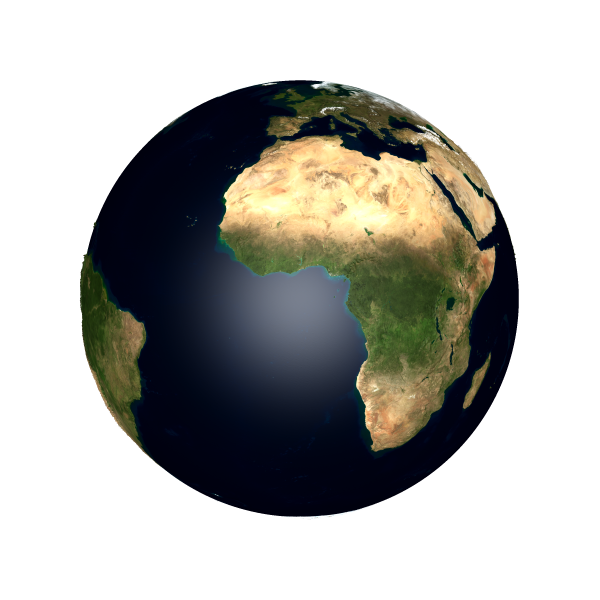

In [10]:
lv = accessvis.plot_earth(texture='bluemarble', background="white", vertical_exaggeration=20)
lv.set_properties(diffuse=0.6, ambient=0.85, specular=0.25, shininess=0.03, light=[1,1,0.98,1], lightpos=[0,0,10000,1])
lv.display(resolution=(600,600))

## lv.video() Arguments and Basic Usage

To create a video in **accessvis**, the best approach is to use the `lv.video()` context manager. Below are the key arguments you can use:

- **filename**: Specifies the path and name of the video file to save.
- **quality**: Controls the quality of the video, with options ranging from 1 (low) to 4 (high), similar to the resolution selector.
- **resolution**: Sets the resolution of the saved video.
- **framerate=30**: Defines the frames per second (FPS) for the video.
- **params="autoplay"**: If included, the video will be displayed within the notebook upon completion.
- **width/height**: Defines the dimensions of the video player in the Jupyter notebook. This can be useful if the video player is too large for your screen.

To generate a frame for the video, call `lv.render()` within the context manager. By adjusting parameters between each `lv.render()` call, your animation will be saved as a video.

A few notes for users working in Jupyter notebooks:
- The default save path may not match the folder where your notebook is located. It's best to specify a full path for the filename.
- On NCI Gadi, the default folder is typically `~/` (your home directory), which might differ from your notebook's location.

Now, let’s look at some examples to see how this works in action!

## Example: Spin and Zoom

In this example, we will demonstrate how to create a simple animation where the Earth spins while zooming in onto Canberra. We will start at the coordinates (0,0) and gradually rotate the Earth while zooming in. To achieve this, we will use `lv.window()` and `lv.camera()` to define the appropriate translations and rotations for the start and end points of the animation.

### Step 1: Define Start and End Points

Before creating the animation, we need to define the start and end points for the camera’s position, as well as the camera's field of view (zoom level). Here’s how to set it up:

In [3]:
num_steps = 150

lat_start = 0
lon_start = 0

lat_end = -149
lon_end = -35

start_height = -20
end_height = -7

latitudes = np.linspace(lat_start, lat_end, num_steps)
longitudes = np.linspace(lon_start, lon_end, num_steps)
heights = np.linspace(start_height, end_height, num_steps)

### Step 2: Create the Video

Now that we have defined our starting and ending points, let's create the video. We will:

1. Use the `lv.video()` context manager to start recording the animation.
2. Iterate through the latitude, longitude, and zoom values over the course of the animation.
3. Update the camera view at each step.
4. Pause on the last frame for a second to hold the final view.

We will use `tqdm` to display a progress bar during the iteration, though this is optional.

### Explanation:
- **Context Manager**: `lv.video()` begins the process of recording the animation to a video file (`spin_and_zoom.mp4`).
- **Camera Movement**: The camera is moved by interpolating between the start and end positions for both latitude and longitude, as well as zoom level.
- **Progress Bar**: `tqdm` provides a progress bar to track the animation's progress (optional).
- **Render**: `lv.render()` captures each frame of the animation.
- **Pause**: A brief pause (`time.sleep(1)`) is added at the end to hold the last frame for a second.

Remember, the video file will be saved in the working directory, which may not be the same as the notebook’s location. You may want to specify an absolute path for saving if necessary.

In [4]:
filename = os.path.abspath('rotate_and_zoom.mp4')
print(filename)

with lv.video(filename=filename, quality=4, resolution=(600,600), width=600, height=600, params="autoplay") as v:
    for lat, lon, h in tqdm(zip(latitudes, longitudes, heights), total=num_steps):
        lv.reset() # Note that we must reset as rotate in this context gives a relative rotation.
        lv.rotate('y',lat)
        lv.rotate('x',lon)
        lv.translation(0, 0, h)
        
        lv.render()

    for _ in range(30): #pause at the end of the video
        lv.render()

/home/563/rb5533/rotate_and_zoom.mp4


Output #0, mp4, to '/home/563/rb5533/rotate_and_zoom.mp4':
  Stream #0:0: Unknown: none


  0%|          | 0/150 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

Here's an improved version:

---

## Example: Annual Maximum Temperature by Year

In this example, we will animate the **annual maximum temperature** for each point on Earth. The animation will span over several years, with the Earth rotating to show the changing temperatures across the globe.

### Steps:
1. We will download historical temperature data from the NCI THREDDS server.
2. The dataset will be processed and animated over time, with the Earth rotating to display the maximum temperature for each year.
3. Each frame will show the global temperature at a particular year, creating an animated time-lapse of temperature changes.

### Data Source:
The temperature data used in this example is historical surface temperature data, sourced from the **NCI THREDDS server**. The dataset covers global temperature data at the Earth's surface and is stored in the NetCDF format. The file is approximately **0.5GB** in size.

> **Note**: If you're running this notebook outside of Gadi, the data will be automatically downloaded. However, if you are on Gadi, the dataset may already be available for access, and you can skip the download step.

This dataset represents the **annual maximum temperature** across the globe, with each frame showing the maximum temperature for one year. By rotating the Earth, you’ll be able to see how the temperature changes around the world from year to year.

In [5]:
thredds_server = "https://thredds.nci.org.au/thredds/fileServer/fs38/publications/"
gadi_server = '/g/data/fs38/publications/'

#Temp at the surface
ver = "CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/"
fpath = "r10i1p1f1/day/tas/gn/latest/tas_day_ACCESS-ESM1-5_historical_r10i1p1f1_gn_20000101-20141231.nc"
var = 'tas'
url = f"{thredds_server}{ver}{fpath}"
gadi_path = f"{gadi_server}{ver}{fpath}"


if os.path.exists(gadi_path):
    data_file = gadi_path
else:
    print('Could not load from gadi.')
    data_file = os.path.abspath(os.path.split(url)[-1])

    if not os.path.exists(data_file):
        print(f'Downloading from {url}')
        print(f'Saving to {data_file}')
        urllib.request.urlretrieve(url, data_file)

print(f'{data_file=}')

data_file='/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r10i1p1f1/day/tas/gn/latest/tas_day_ACCESS-ESM1-5_historical_r10i1p1f1_gn_20000101-20141231.nc'


## Preparing the Data

Before we can animate the temperature data, let's first prepare it. We will:

1. **Read the Data**: Load the temperature data from the NetCDF file into an `xarray` object.
2. **Extract the Maximum Temperature for Each Year**: Calculate the annual maximum temperature at each grid point.
3. **Visual Check for the Year 2000**: Plot the data for the year 2000 to verify that the maximum temperature values are correctly extracted.

This step ensures that the data is processed correctly before we proceed with the animation. By visualising the temperature data for the year 2000, we can confirm that the maximum temperature values are accurate.

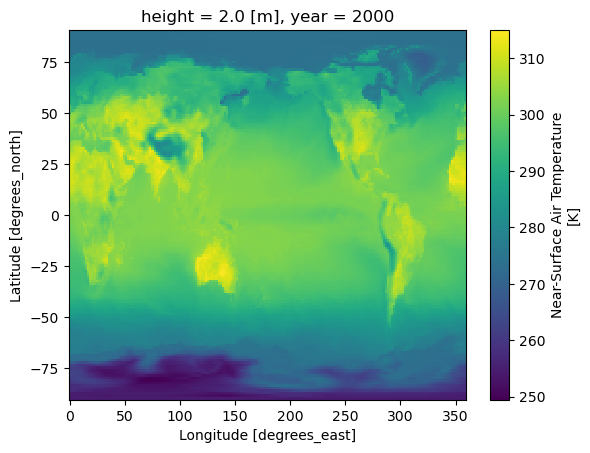

In [6]:
ds = xr.open_dataset(data_file)

yearly_maximum = ds['tas'].groupby('time.year').max(dim='time')

yearly_maximum.sel(year=2000).plot()

## Preparing for the Animation

To ensure a smooth and consistent animation, we need to make a few preparations:

1. **Colour Consistency**: Find the maximum and minimum temperature values across the entire time range. This ensures that the Earth's surface is coloured consistently throughout the animation, regardless of the specific year being shown.
2. **Camera Position**: Define the camera's movement. We will spin the Earth 360 degrees while keeping the camera focused on a specific location.
3. **Add a Colourbar**: Include a colourbar to visually represent the temperature scale, helping to interpret the colours on the Earth during the animation.

These steps will ensure that the animation is both visually appealing and informative.

In [7]:
filename = os.path.abspath('rotate_and_time_max_temp.mp4')
print(filename)

min_t = float(yearly_maximum.min())
max_t = float(yearly_maximum.max())

# Camera location
y_360 = np.linspace(0, 360, num=90, endpoint=False) # num = 30fps * 3seconds = 90
height = -20 # How zoomed the camera is.



/home/563/rb5533/rotate_and_time_max_temp.mp4


In [8]:
# !!!! If you run this multiple times, you get multiple colourbars.
colourmap='coolwarm'
cmap = lv.colourmap(colourmap, range=(min_t, max_t))
cb = lv.colourbar()

## Animation Time!

Now it's time to create the animation! In the following code, we:

1. **Iterate through each year**: For each year in the dataset, we update the colour scheme and plot the corresponding data. Note that we need to flip the data for proper alignment.
2. **Update the Title**: For each frame, we update the title to display the year being visualised.
3. **Render the Image**: We spin the Earth 360 degrees, creating a dynamic effect as the globe rotates.

While we use **tqdm** for a progress bar, it’s not required for functionality—it's just a visual aid to track progress.

Let’s get started with the animation!

In [9]:
with lv.video(filename=filename, quality=4, resolution=(600,600), width=600, height=600, params="autoplay") as v:
    for year in tqdm(yearly_maximum.year.values):
        data = yearly_maximum.sel(year=year)
        colours = accessvis.array_to_rgba(data, colourmap=colourmap, minimum=min_t, maximum=max_t, flip=True)
        accessvis.update_earth_values(lv, dataMode=0, dataAlpha=1, data=colours)
        
        lv.title(f'Annual Maximum Temperature - {year}', fontsize=100)

        for y in y_360:
            lv.reset() # Note that we must reset as rotate in this context gives a relative rotation.
            lv.rotate('y', y)
            lv.translation(0, 0, height)
            lv.render()

  0%|          | 0/15 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>